In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramzitalhouk","key":"5930ddaf8c75d7d8d5a6223bc31ab140"}'}

In [3]:
! cp ./kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download grassknoted/asl-alphabet
! kaggle datasets download danrasband/asl-alphabet-test

 99% 1.02G/1.03G [00:24<00:00, 47.7MB/s]
100% 1.03G/1.03G [00:24<00:00, 44.8MB/s]
 70% 17.0M/24.3M [00:00<00:00, 12.2MB/s]
100% 24.3M/24.3M [00:00<00:00, 29.4MB/s]


In [4]:
! unzip asl-alphabet.zip -d asl_alphabet
! unzip asl-alphabet-test.zip -d asl_alphabet

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing766.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing767.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing768.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing769.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing77.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing770.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing771.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing772.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing773.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing774.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_tr

In [5]:
import os

letters = [chr(i) for i in range(ord("A"), ord("Z") + 1)]
letters.insert(4, "del")
letters.insert(15, "nothing")
letters.insert(21, "space")

for letter in letters:
  os.system(f"mv asl_alphabet/{letter}/* asl_alphabet/asl_alphabet_train/asl_alphabet_train/{letter}/")
  os.system(f"rmdir asl_alphabet/{letter}/")
  os.system(f"mv asl_alphabet/asl_alphabet_test/{letter}/* asl_alphabet/asl_alphabet_train/asl_alphabet_train/{letter}/")
  os.system(f"rmdir asl_alphabet/asl_alphabet_test/{letter}/")
  print("Moved", letter)

Moved A
Moved B
Moved C
Moved D
Moved del
Moved E
Moved F
Moved G
Moved H
Moved I
Moved J
Moved K
Moved L
Moved M
Moved N
Moved nothing
Moved O
Moved P
Moved Q
Moved R
Moved S
Moved space
Moved T
Moved U
Moved V
Moved W
Moved X
Moved Y
Moved Z


In [6]:
from keras import layers, Sequential, metrics
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import pickle
import time
import pathlib
from typing import Tuple, Any, Optional
from sklearn.model_selection import KFold
import math


data_augmentation = Sequential([
                                layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(80, 80,3)),
                                layers.experimental.preprocessing.RandomRotation(0.1),
                                layers.experimental.preprocessing.RandomZoom(0.1),
                                ])

def load_image_dataset(image_dir, batch_size, img_height, img_width) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    data_dir = pathlib.Path(image_dir)
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)
    
    return train_ds, val_ds


def fit_cnn(train_ds: tf.data.Dataset, val_ds: tf.data.Dataset) -> Tuple[
    Sequential, Any]:
    start = time.time()
    model = Sequential([
                        data_augmentation,
                        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(80, 80, 3)),
                        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(80, 80, 3), padding="same"),
                        layers.MaxPooling2D(),
                        layers.Dropout(0.1),
                        layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
                        layers.MaxPooling2D(),
                        layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
                        layers.Dropout(0.2),
                        layers.Flatten(),
                        layers.Dense(64, activation='relu'),
                        layers.Dense(29)
                        ])
    model.compile(optimizer=Adam(),
                  loss=SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history = model.fit(train_ds, epochs=100,
                        validation_data=val_ds)
    model.save("./drive/MyDrive/model4")
    print("CNN fit finished in:", (time.time() - start) / 3600, "hours")
    print("Model Summmary:", model.summary())
    return model, history

def cross_validation(img_dir, img_height, img_width, folds) -> None:
  data_dir = pathlib.Path(img_dir)
  dataset = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      image_size=(img_height, img_width),
      batch_size = 32)
  model = Sequential([
                      data_augmentation,
                      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(80, 80, 3)),
                      layers.Conv2D(16, (3, 3), activation='relu', input_shape=(80, 80, 3), padding="same"),
                      layers.MaxPooling2D(),
                      layers.Dropout(0.1),
                      layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
                      layers.MaxPooling2D(),
                      layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
                      layers.Dropout(0.2),
                      layers.Flatten(),
                      layers.Dense(64, activation='relu'),
                      layers.Dense(29)
                      ])
  model.compile(optimizer=Adam(),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  fold_size = math.floor(87870/32/5)
  for i in range(folds):
    print(dataset.__len__())
    train_ds = dataset.take(i*fold_size).concatenate(dataset.skip((i+1)*fold_size)) if i != 0 else dataset.skip((i+1)*fold_size)
    print(train_ds.__len__())
    val_ds = dataset.skip(i*fold_size).take(fold_size) if i != 0 else dataset.take(fold_size)
    print(val_ds.__len__())
    history = model.fit(train_ds, epochs=50, validation_data=val_ds)

                  

def evaluate_cnn(history) -> None:
    start = time.time()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(100)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    print("CNN scoring finished in:", time.time() - start, "seconds")

def train_cnn_model() -> None:
    train_ds, val_ds = load_image_dataset("/content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/", 32, 80, 80)
    model, metrics = fit_cnn(train_ds, val_ds)
    evaluate_cnn(metrics)

Found 87870 files belonging to 29 classes.
Using 70296 files for training.
Found 87870 files belonging to 29 classes.
Using 17574 files for validation.
Epoch 1/100
2197/2197 [==============================] - 80s 36ms/step - loss: 2.0759 - accuracy: 0.3684 - val_loss: 1.0923 - val_accuracy: 0.6328
Epoch 2/100
2197/2197 [==============================] - 79s 36ms/step - loss: 1.0309 - accuracy: 0.6593 - val_loss: 0.6159 - val_accuracy: 0.7904
Epoch 3/100
2197/2197 [==============================] - 78s 36ms/step - loss: 0.7170 - accuracy: 0.7571 - val_loss: 0.5813 - val_accuracy: 0.7953
Epoch 4/100
2197/2197 [==============================] - 78s 36ms/step - loss: 0.5581 - accuracy: 0.8130 - val_loss: 0.3299 - val_accuracy: 0.8923
Epoch 5/100
2197/2197 [==============================] - 79s 36ms/step - loss: 0.4719 - accuracy: 0.8417 - val_loss: 0.3000 - val_accuracy: 0.8990
Epoch 6/100
2197/2197 [==============================] - 79s 36ms/step - loss: 0.4068 - accuracy: 0.8633 - val_lo

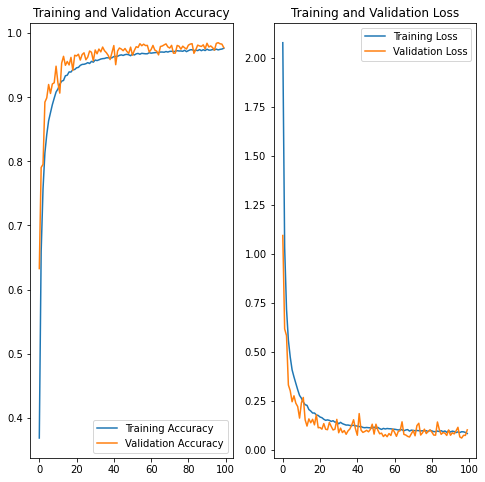

CNN scoring finished in: 0.28315091133117676 seconds


In [ ]:
train_cnn_model()

In [9]:
import tensorflow as tf
import pathlib
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image_dataset_from_directory
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from tensorflow.nn import softmax
import numpy as np
import tensorflow_datasets as tfds
from typing import Tuple

letters = [chr(i) for i in range(ord("A"), ord("Z") + 1)]
letters.insert(4, "del")
letters.insert(15, "nothing")
letters.insert(21, "space")

letter_map = {i: letter for i, letter in enumerate(letters)}

def score(model, test_data) -> Tuple[dict, np.array]:
    target = None
    preds = None
    class_probs = None
    for image_batch, label_batch in tfds.as_numpy(test_data):
        if target is None:
            target = label_batch
        else:
            target = np.append(target, label_batch)
        predictions = model.predict(image_batch)
        classes = []
        scores = []
        ins_class_probs = []
        for i, p in enumerate(predictions):
            score = softmax(p)
            classes.append(np.argmax(score))
            scores.append(score[label_batch[i]])
            ins_class_probs.append(score.numpy())
        if preds is None:
            preds = np.array(classes)
            class_probs = np.array(ins_class_probs)
        else:
            preds = np.append(preds, np.array(classes))
            class_probs = np.append(class_probs, np.array(ins_class_probs))

    pred = pd.Series(preds).replace(letter_map)
    target = pd.Series(target).replace(letter_map)
    report = classification_report(target, pred, output_dict=True)
    bin_targets = label_binarize(target, classes=list(letter_map.values()))
    auc_score = roc_auc_score(bin_targets, class_probs.reshape((-1, 29)), average="micro")
    conf_matrix = confusion_matrix(target, pred)
    fpr, tpr, _ = roc_curve(bin_targets.ravel(), class_probs)
    return report, conf_matrix, (fpr, tpr), auc_score
    

def graph_report(report, conf_matrix, rates, auc, prf_y_range=.7):
    data = pd.DataFrame(columns=["letter", "score", "type"])
    for letter in letters:
        precision = report[letter]["precision"]
        recall = report[letter]["recall"]
        f1 = report[letter]["f1-score"]
        data = data.append({"letter": letter,
                            "score": precision,
                            "type": "precision"}, ignore_index=True)
        data = data.append({"letter": letter,
                            "score": recall,
                            "type": "recall"}, ignore_index=True)
        data = data.append({"letter": letter,
                            "score": f1,
                            "type": "F1 score"}, ignore_index=True)
    sns.barplot(data=data, x="letter", y="score", hue="type")
    plt.xticks(rotation=90)
    plt.ylim(prf_y_range, 1)
    plt.show()
    plt.figure(figsize=(30, 10))
    sns.heatmap(conf_matrix, annot=True, square=False,
                xticklabels=letter_map.values(), yticklabels=letter_map.values())
    plt.xticks(rotation=90)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.show()
    sns.lineplot(x=[0, 1], y=[0, 1])
    ax = sns.lineplot(x=rates[0], y=rates[1])
    ax.text(.75, 0, "AUC: {:.5f}".format(auc), bbox={"boxstyle": "round"})
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

def load_test_dataset(image_dir, batch_size, img_height, img_width) -> tf.data.Dataset:
    data_dir = pathlib.Path(image_dir)
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='int')
    return val_ds

def score_loaded_model():
  val_ds = load_test_dataset("/content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/", 32, 80, 80)
  model = load_model("./drive/MyDrive/model3/")
  report, conf_matrix, rates, auc = score(model, val_ds)
  print(f"Confusion Matrix:\n{conf_matrix}")
  graph_report(report, conf_matrix, rates, auc)


Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Confusion Matrix:
[[632   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  5 593   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   3   0   0]
 [  1   0 598   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 623   2   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0 590   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   1   0   0 602   0   0   2   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 629   0   0   0   0   0   0   0   1   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0 589   0   0   0   0   0   0 

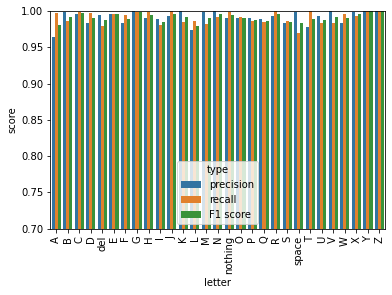

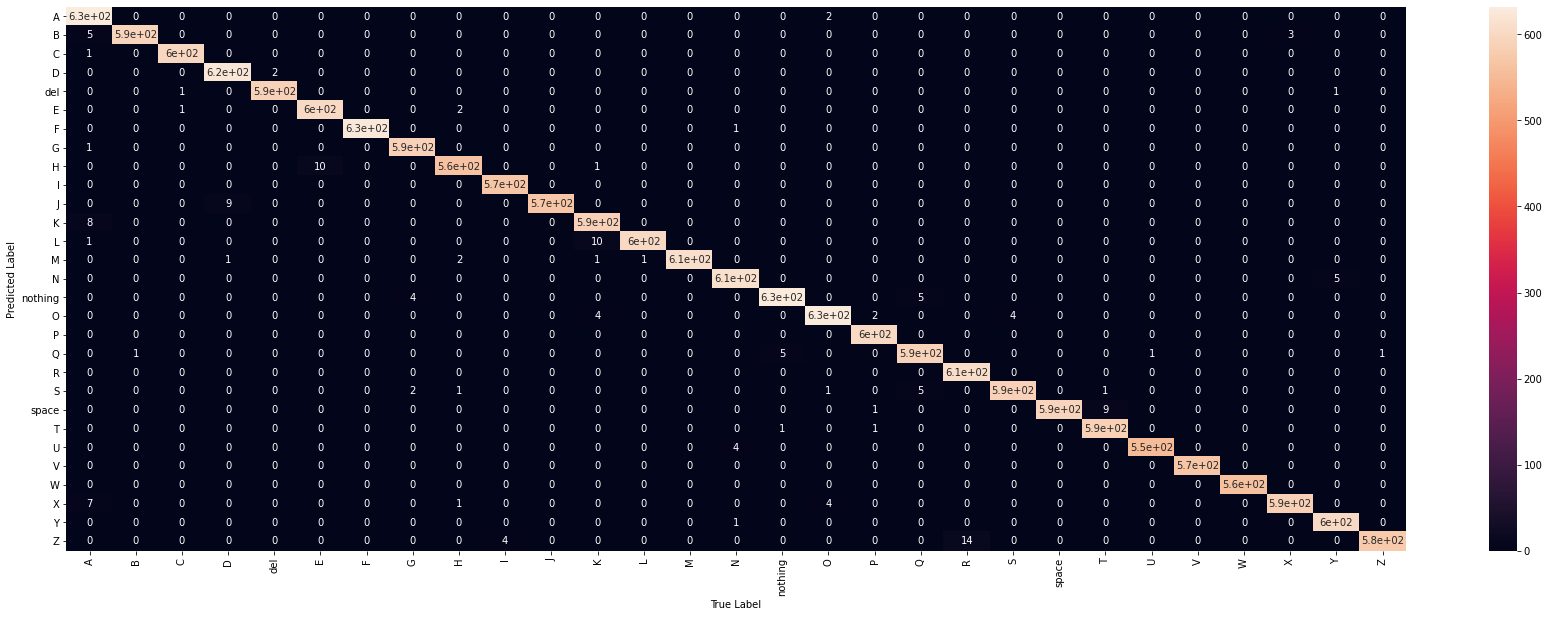

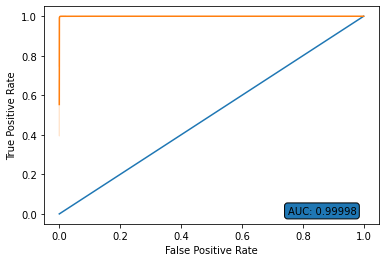

In [10]:
score_loaded_model()

In [ ]:
cross_validation("/content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/", 80, 80, 5)

Found 87870 files belonging to 29 classes.
tf.Tensor(2746, shape=(), dtype=int64)
tf.Tensor(2197, shape=(), dtype=int64)
tf.Tensor(549, shape=(), dtype=int64)
Epoch 1/50
2197/2197 [==============================] - 82s 37ms/step - loss: 2.2126 - accuracy: 0.3306 - val_loss: 1.1752 - val_accuracy: 0.6231
Epoch 2/50
2197/2197 [==============================] - 81s 37ms/step - loss: 1.1103 - accuracy: 0.6375 - val_loss: 0.7600 - val_accuracy: 0.7474
Epoch 3/50
2197/2197 [==============================] - 80s 36ms/step - loss: 0.7315 - accuracy: 0.7542 - val_loss: 0.4850 - val_accuracy: 0.8404
Epoch 4/50
2197/2197 [==============================] - 81s 37ms/step - loss: 0.5540 - accuracy: 0.8159 - val_loss: 0.3781 - val_accuracy: 0.8761
Epoch 5/50
2197/2197 [==============================] - 80s 36ms/step - loss: 0.4536 - accuracy: 0.8470 - val_loss: 0.3216 - val_accuracy: 0.8981
Epoch 6/50
2197/2197 [==============================] - 78s 36ms/step - loss: 0.3894 - accuracy: 0.8706 - val_l